# Ranking PNLs Demo

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Setting some constraints
STARTING_VALUE = 100
MINIMUM_VALUE = STARTING_VALUE * 0.2

# Set the seed
random.seed(123)

# Create dates for 3 years
dates = pd.date_range(start="2021-01-01", end="2023-12-01", freq="MS")

In [3]:
# Generate a set of PNLs to judge
PNLs = {}
for index in range(10):
    # Initialize lists
    cumulative_pnls = []
    
    # Generate PNL values ensuring the constraints
    cumulative = STARTING_VALUE
    for _ in dates:
        pnl = random.randint(-1000, 1000)
        temp_cumulative = cumulative + pnl
        while temp_cumulative < MINIMUM_VALUE:
            pnl = random.randint(-1000, 1000)
            temp_cumulative = cumulative + pnl
        cumulative = temp_cumulative
        cumulative_pnls.append(cumulative)
    
    # Normalize values
    min_value = cumulative_pnls[0]
    max_value = cumulative_pnls[-1]
    normalized_pnls = [(x - min_value) / (max_value - min_value) for x in cumulative_pnls]
    
    # Compute straight line values
    X = np.array(range(len(dates)))
    y1, y2 = normalized_pnls[0], normalized_pnls[-1]
    straight_line_values = y1 + (y2 - y1) / (X[-1] - X[0]) * (X - X[0])
    
    # Calculate residuals and sum of squares
    residuals = np.array(normalized_pnls) - straight_line_values
    sum_of_squares = np.sum(residuals ** 2).item()
    
    # Create DataFrame
    dict = {
        'Date': dates,
        'Cumulative PNL': cumulative_pnls,
        'Normalized PNL': normalized_pnls,
        'Straight Line PNL': straight_line_values,
        'SSE': sum_of_squares
    }
    PNLs[index] = dict

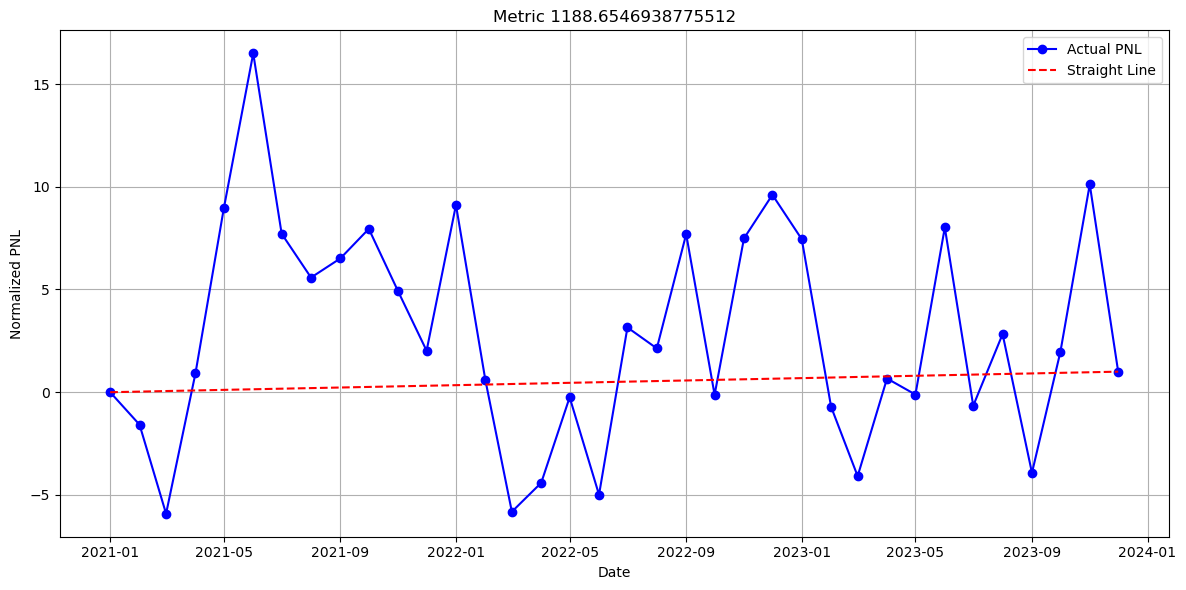

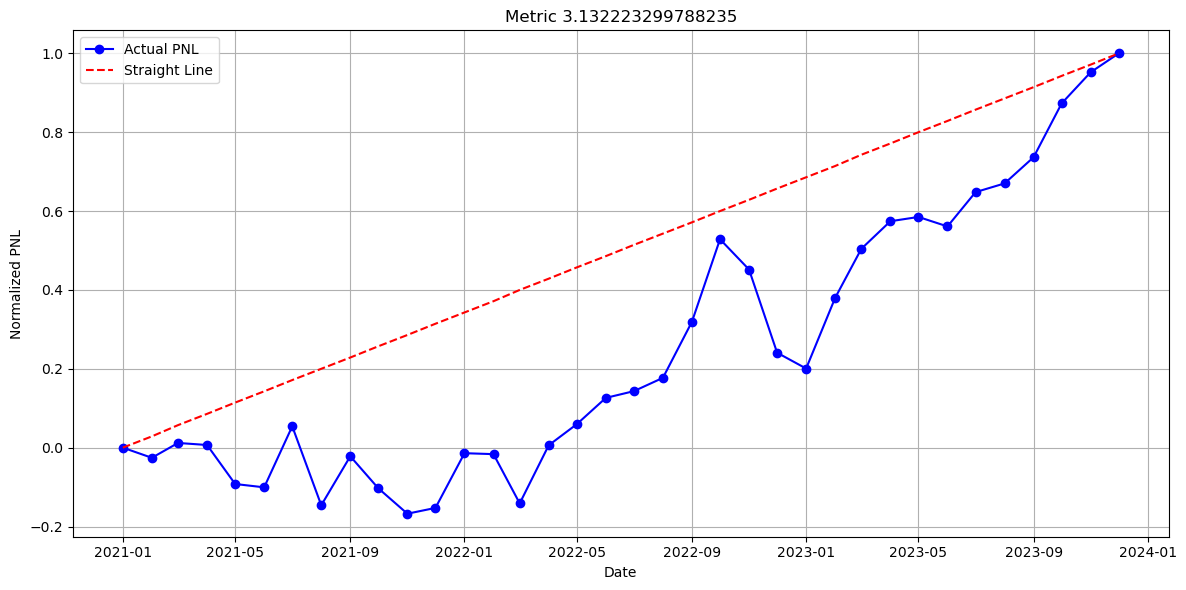

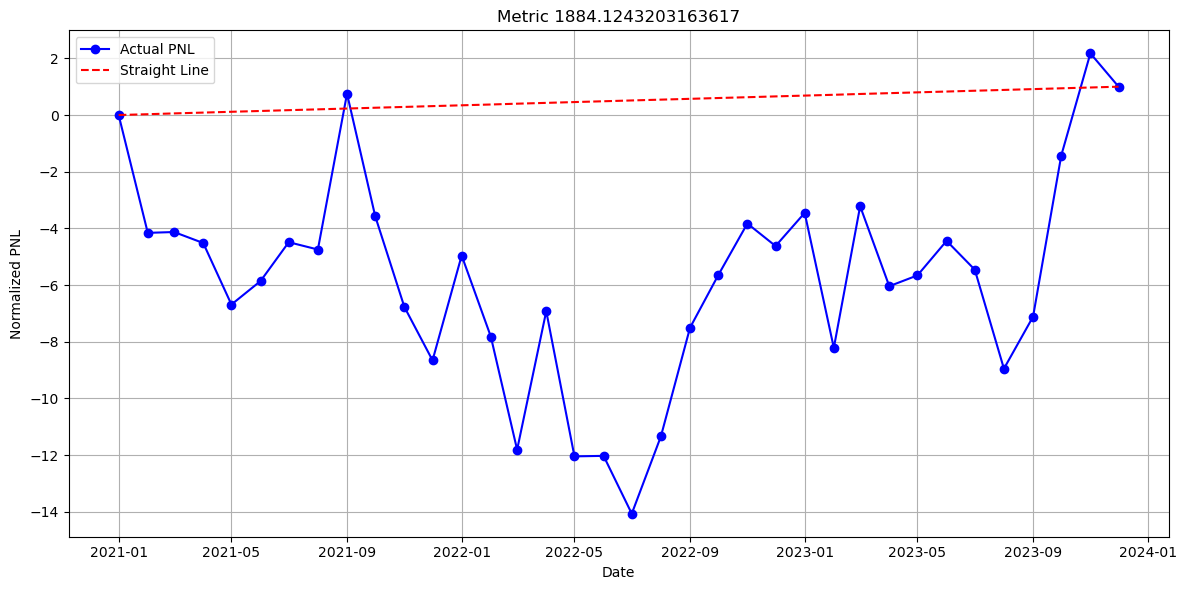

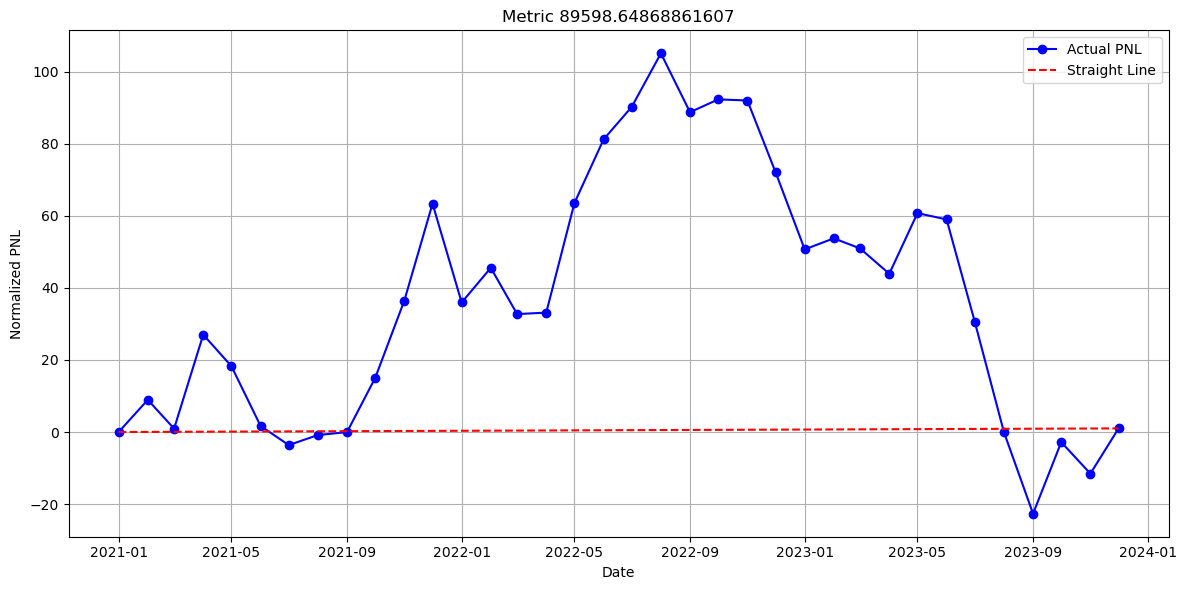

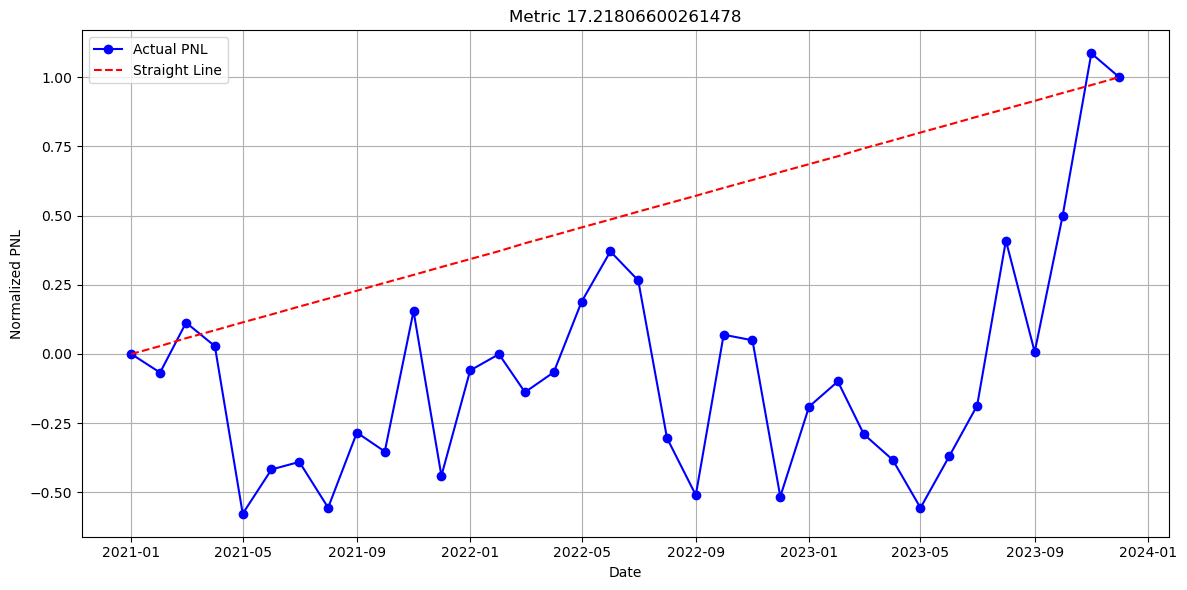

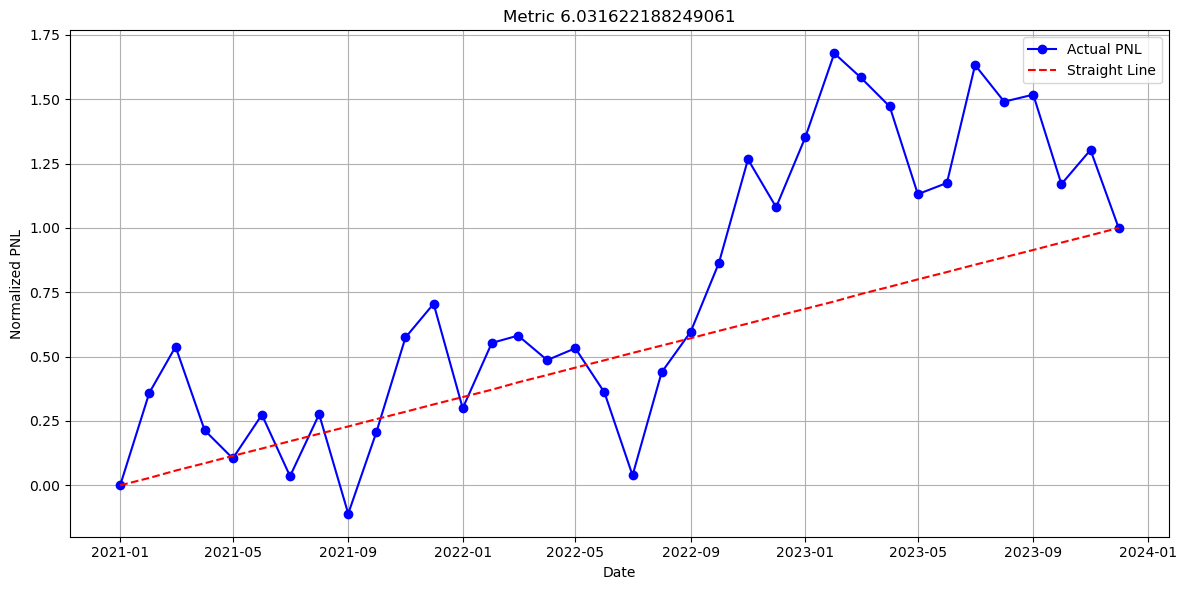

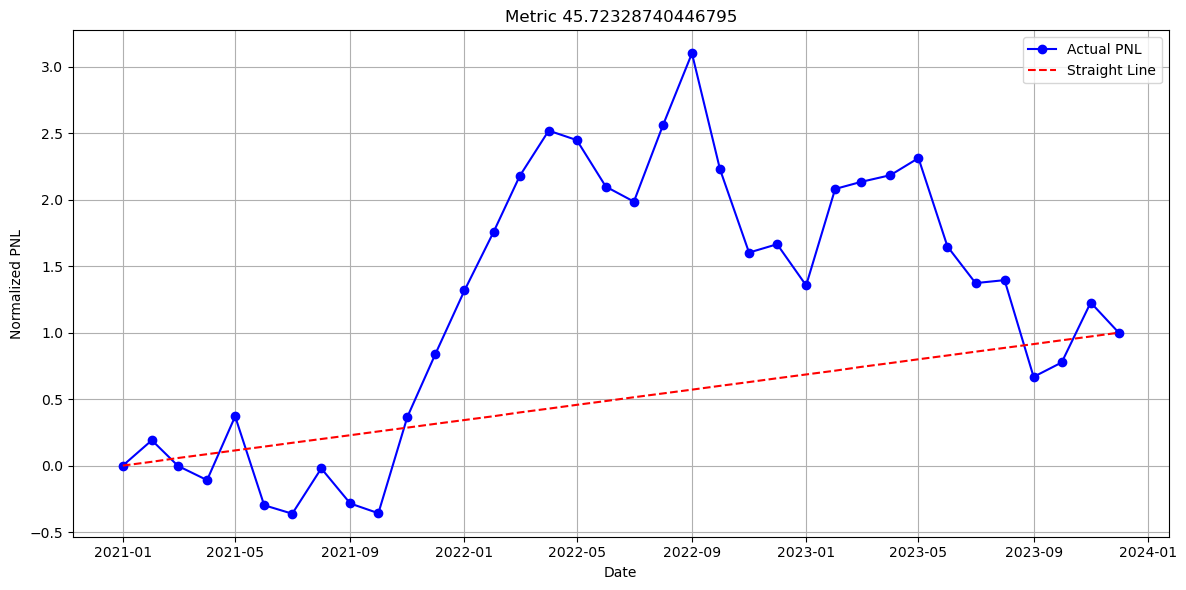

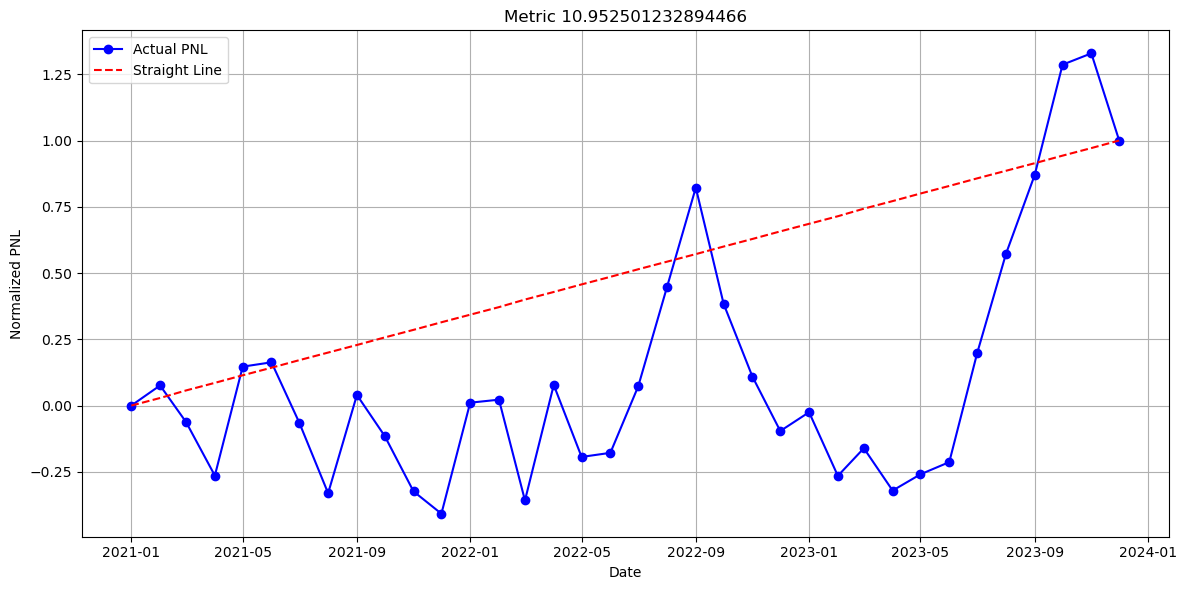

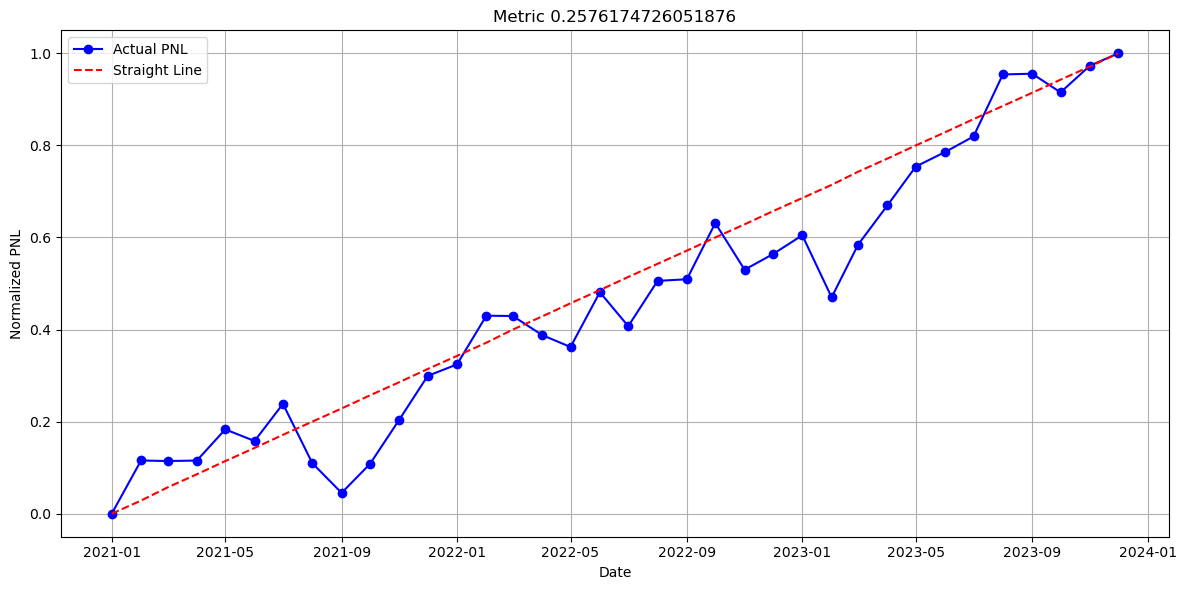

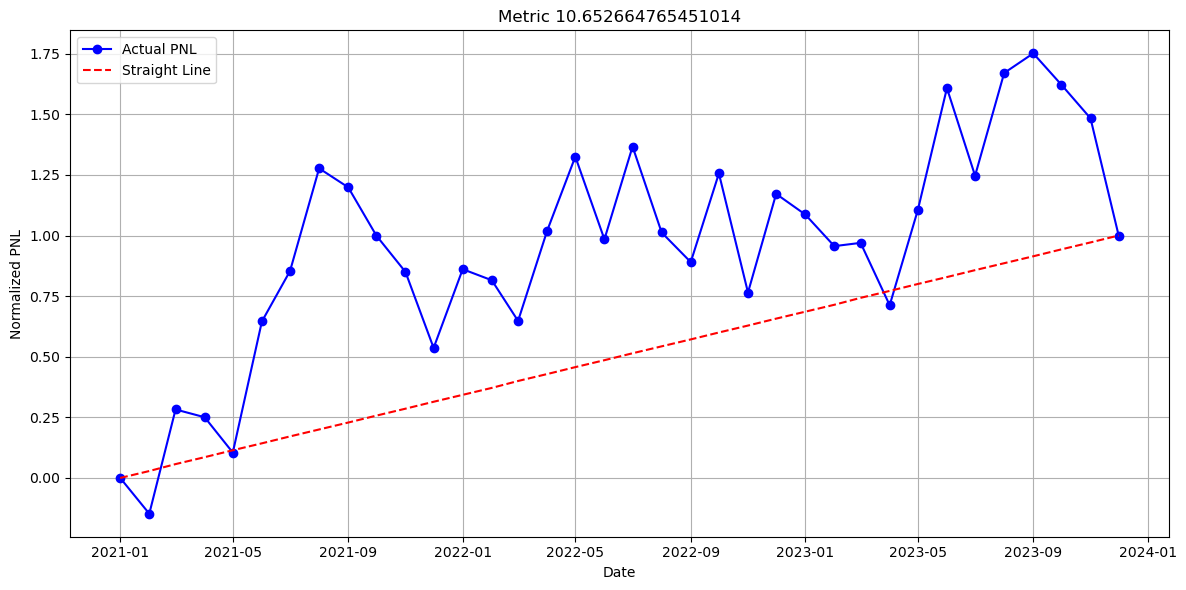

In [4]:
# Plot the PNLs
for index in PNLs:
    dict = PNLs[index]
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(dict['Date'], dict['Normalized PNL'], marker='o', linestyle='-', color='b', label="Actual PNL")
    plt.plot(dict['Date'], dict['Straight Line PNL'], color='r', linestyle='--', label="Straight Line")
    plt.title(f"Metric {dict['SSE']}")
    plt.xlabel('Date')
    plt.ylabel('Normalized PNL')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
df = pd.DataFrame(PNLs).T

# Normalize with a MinMaxScaler

This doesn't work out very well. The normalized values are too close to make a good distinction when rounded.

In [6]:
df['SSE_normalized'] = (1 - MinMaxScaler().fit_transform(df[['SSE']])).round(3)

In [7]:
df[['SSE_normalized', 'SSE']].sort_values('SSE_normalized', ascending=False)

,SSE_normalized,SSE
1,1.000,3.132223
5,1.000,6.031622
9,1.000,10.652665
4,1.000,17.218066
8,1.000,0.257617
7,1.000,10.952501
6,0.999,45.723287
0,0.987,1188.654694
2,0.979,1884.12432
3,0.000,89598.648689


# Use Pipeline Transformations

These nonlinear transforms prior to scaling works much better for these ranges. Need to test with different ranges.

In [8]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [9]:
def log_transform(x):
    return np.log(x + 1)

def sqrt_transform(x):
    return np.sqrt(x)

In [10]:
scaler = MinMaxScaler()
transformer = FunctionTransformer(log_transform)
pipe = Pipeline(steps=[('transformer', transformer), ('scaler', scaler)])

df['SSE_lognormal'] = (1 - pipe.fit_transform(df['SSE'].to_numpy(dtype='float32').reshape(-1, 1))).round(3)

In [11]:
scaler = MinMaxScaler()
transformer = FunctionTransformer(sqrt_transform)
pipe = Pipeline(steps=[('transformer', transformer), ('scaler', scaler)])

df['SSE_sqrtnormal'] = (1 - pipe.fit_transform(df['SSE'].to_numpy(dtype='float32').reshape(-1, 1))).round(3)

In [12]:
df[['SSE_normalized', 'SSE_lognormal', 'SSE_sqrtnormal', 'SSE']]

,SSE_normalized,SSE_lognormal,SSE_sqrtnormal,SSE
0,0.987,0.387,0.886,1188.654694
1,1.000,0.894,0.996,3.132223
2,0.979,0.346,0.856,1884.12432
3,0.000,-0.000,0.000,89598.648689
4,1.000,0.761,0.988,17.218066
5,1.000,0.846,0.993,6.031622
6,0.999,0.676,0.979,45.723287
7,1.000,0.798,0.991,10.952501
8,1.000,1.000,1.000,0.257617
9,1.000,0.801,0.991,10.652665


In [13]:
df.sort_values('SSE_normalized', ascending=False).index

Index([1, 5, 9, 4, 8, 7, 6, 0, 2, 3], dtype='int64')

In [14]:
df.sort_values('SSE_lognormal', ascending=False).index

Index([8, 1, 5, 9, 7, 4, 6, 0, 2, 3], dtype='int64')

In [15]:
df.sort_values('SSE_sqrtnormal', ascending=False).index

Index([8, 1, 5, 7, 9, 4, 6, 0, 2, 3], dtype='int64')

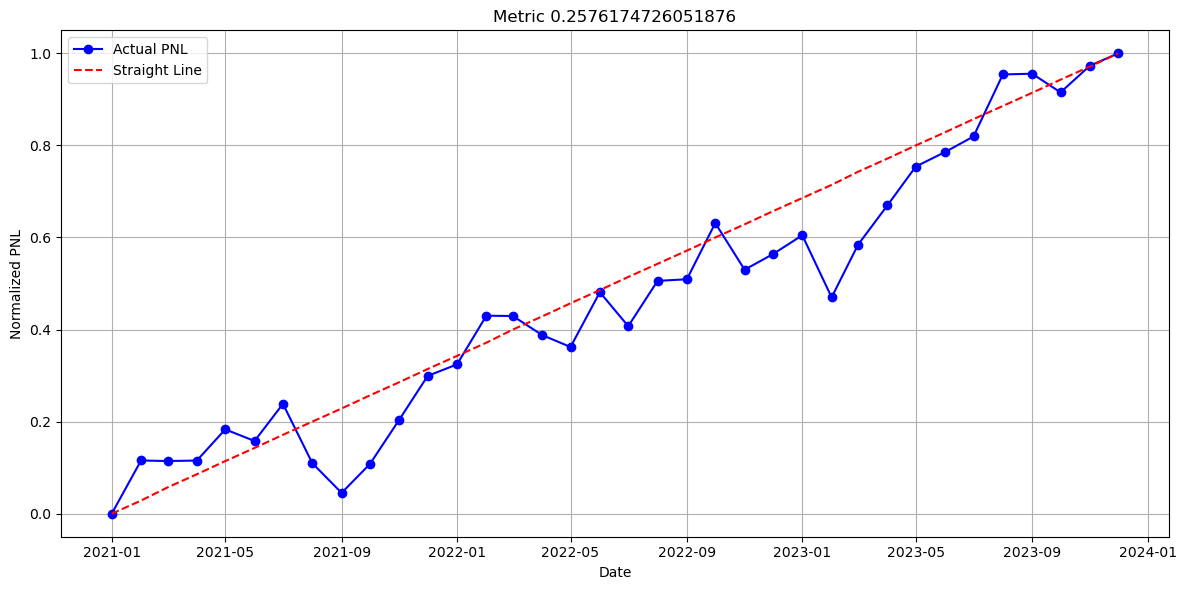

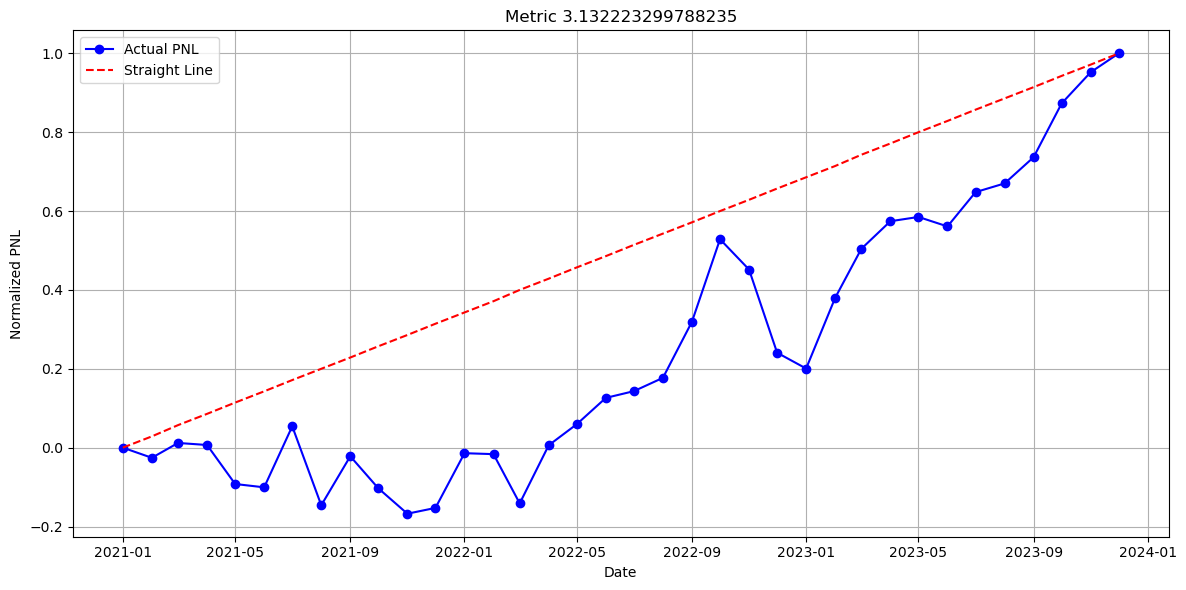

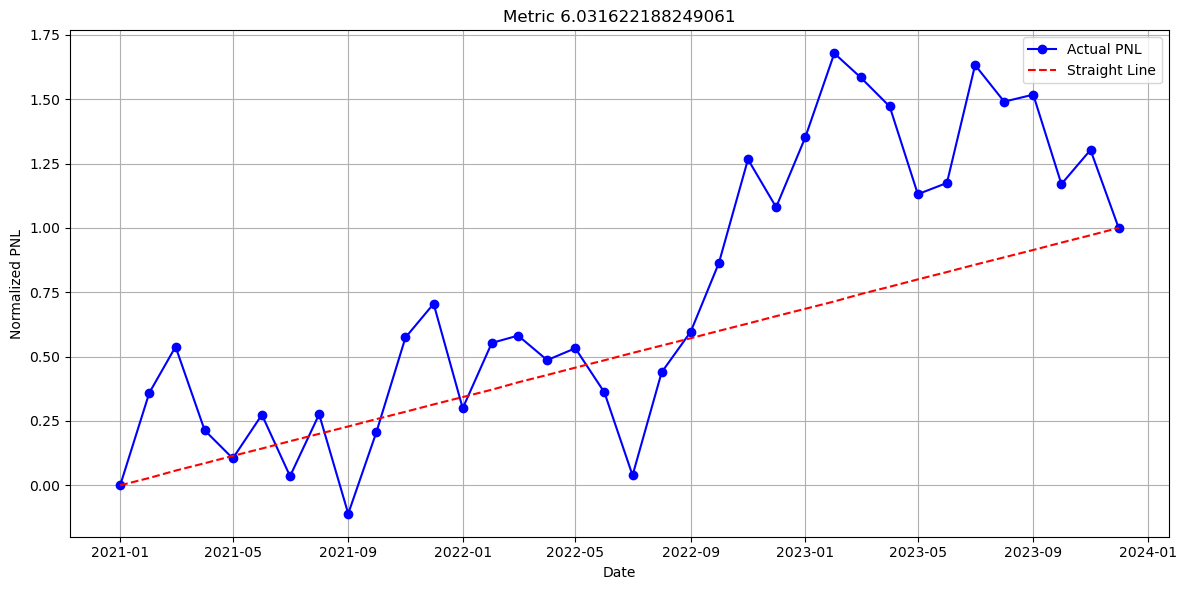

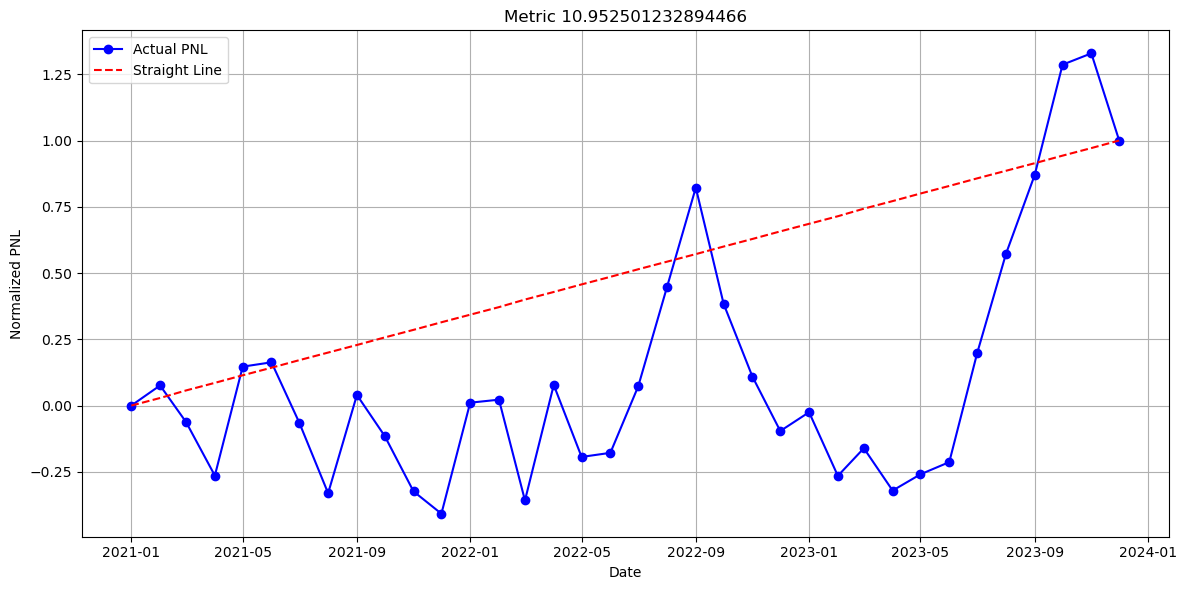

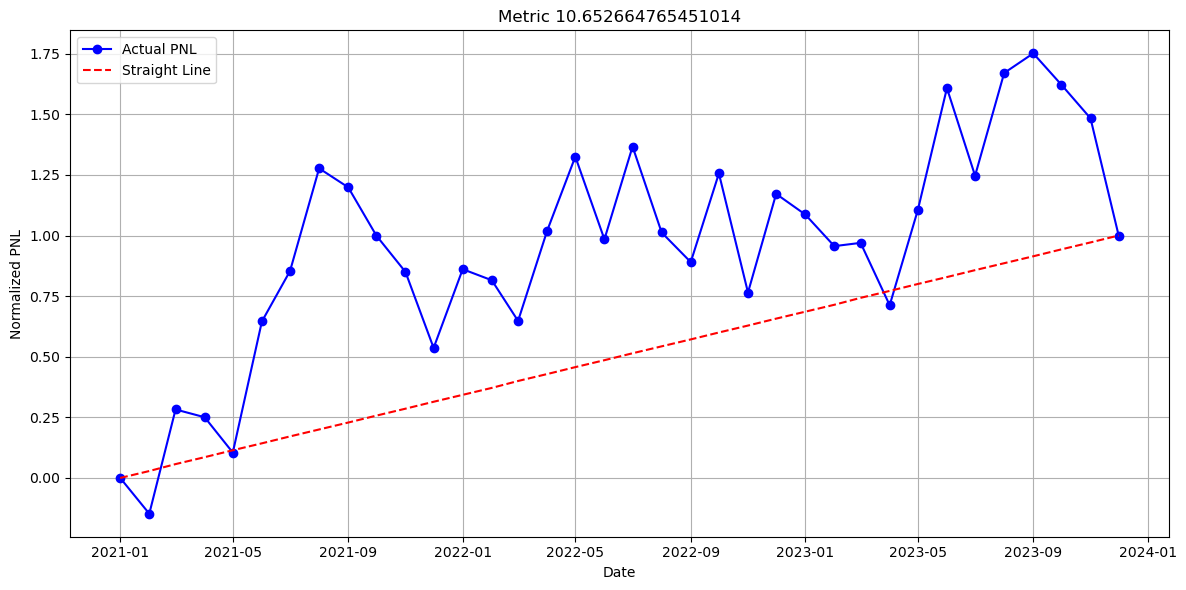

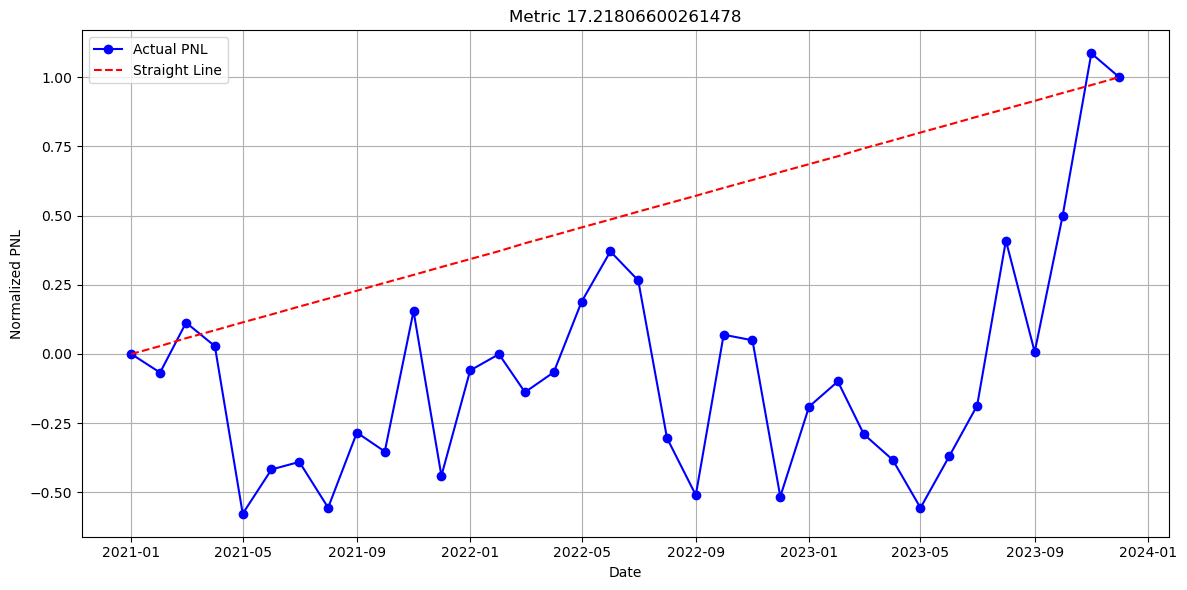

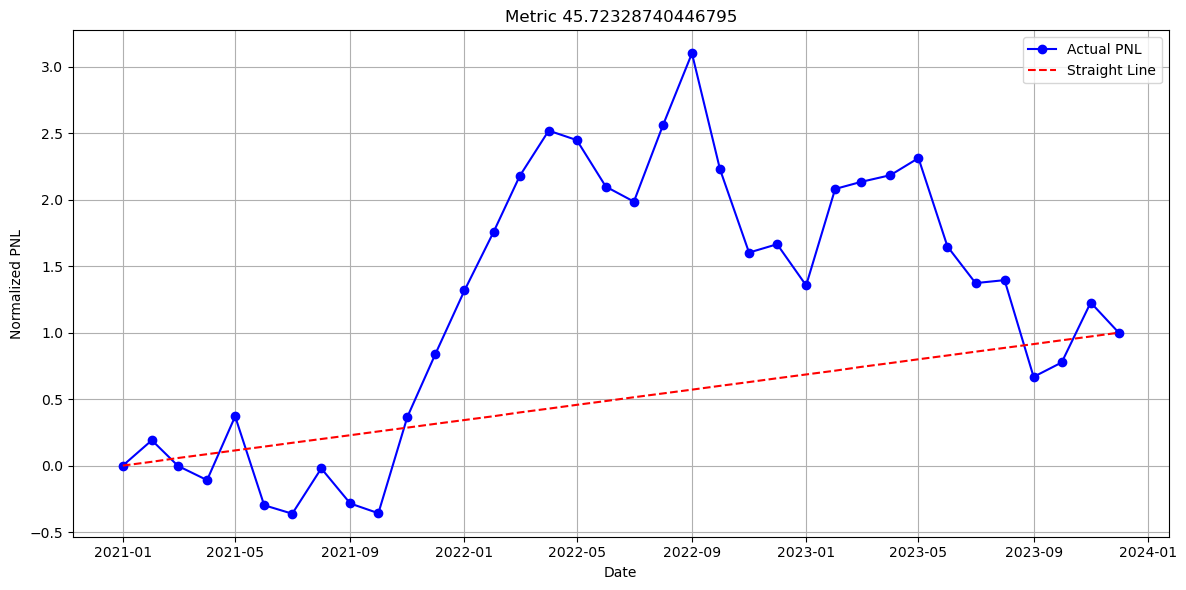

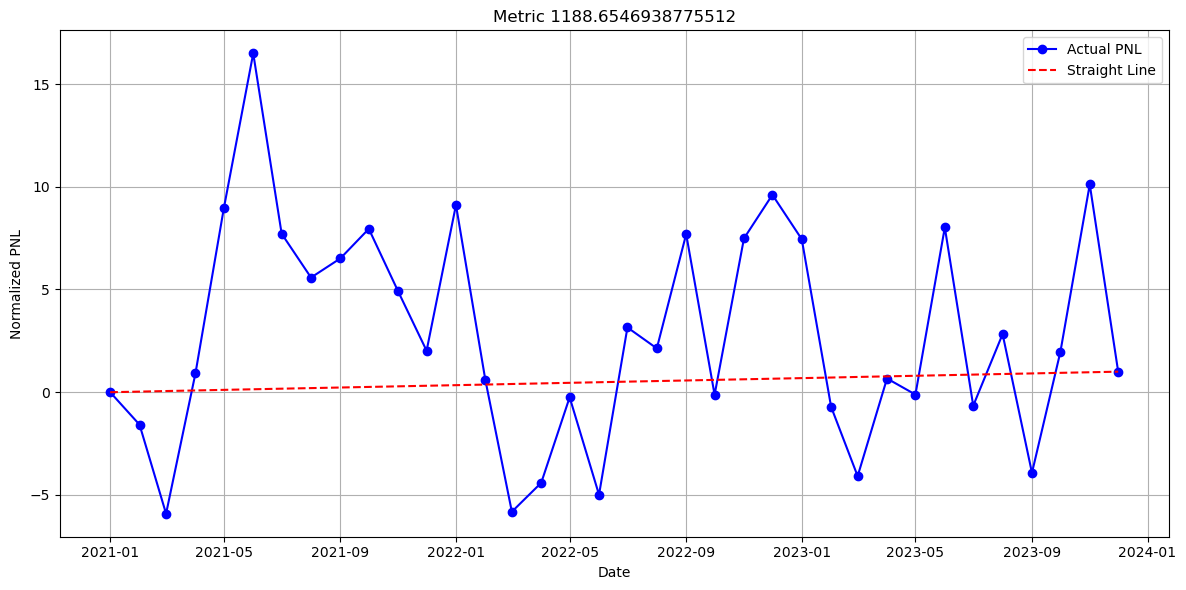

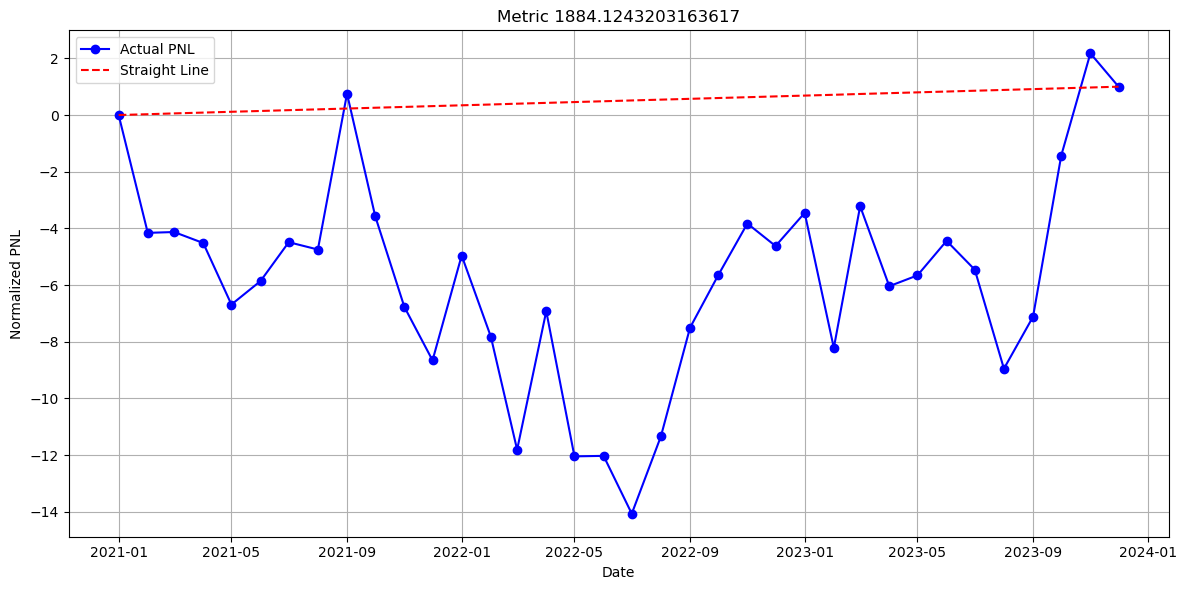

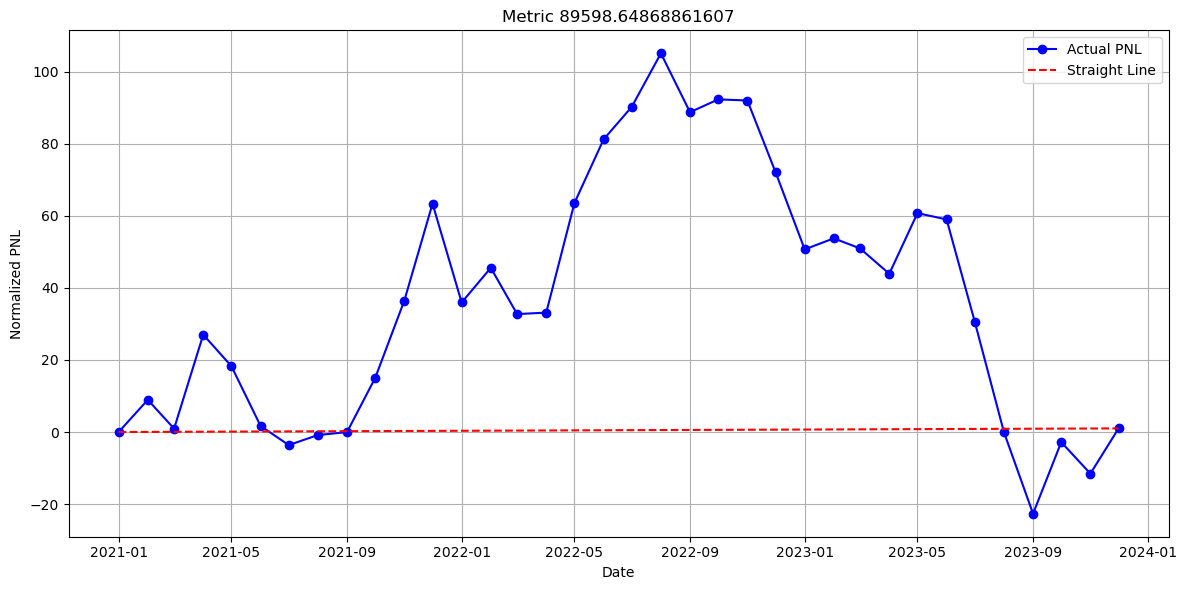

In [16]:
for index in df.sort_values('SSE_sqrtnormal', ascending=False).index:
    dict = PNLs[index]
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(dict['Date'], dict['Normalized PNL'], marker='o', linestyle='-', color='b', label="Actual PNL")
    plt.plot(dict['Date'], dict['Straight Line PNL'], color='r', linestyle='--', label="Straight Line")
    plt.title(f"Metric {dict['SSE']}")
    plt.xlabel('Date')
    plt.ylabel('Normalized PNL')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()